The file is for predicting failure. The target column of the dataset is used. The model is an ensmble technique based stacking classifier with base models Random Forest, Gradient Boosting and Support Vector Machine classifiers.  

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique, mean, std
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [2]:
# importing dataset from github
url = "https://raw.githubusercontent.com/MHBaloch/Machine-Learning-/main/Data.csv" # importing url
dataset = pd.read_csv(url) # reading data fro url
data = dataset # creating dataframe
data.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure


# Data Pre-processing

## Feature Engineering

In [3]:
# creating new columns based on the input variables and described in data description
data['Power'] = data['Rotational speed [rpm]']*data['Torque [Nm]']
data['Overstrain'] = data['Tool wear [min]']*data['Torque [Nm]']
data['Temperature'] = data['Process temperature [K]']-data['Air temperature [K]']
#data_df = data.drop(['Air temperature [K]','Process temperature [K]','Torque [Nm]'], axis=1)
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,74001.2,247.0,10.4
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,56603.5,276.5,10.4
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,56320.0,360.0,10.5


## Data Cleaning

In [4]:
# droping nominal numerical features
df = data.drop(['UDI','Product ID'], axis = 1)
df.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5


In [5]:
# total count of failures except No Failure
df_f_type = df[df['Failure Type'].isin(['Power Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Tool Wear Failure', 'Random Failures'])]
len(df_f_type)

348

In [6]:
# dropping wrong/ambiguous values
df_failure = df[df['Target']>=1]
df_f_true = df_failure[df_failure['Failure Type']!='No Failure']
df_no_f_true = df[(df['Failure Type']=='No Failure') & (df['Target']<=0)]
df_true = pd.concat([df_f_true,df_no_f_true]).reset_index(drop=True)
data.shape ,df_true.shape

((10000, 13), (9973, 11))

## Data Transformation

In [7]:
# labeling categorical column 'Failure Type' with numerical values.
df_ = df_true.copy()
encoder = LabelEncoder()
df_['Failure Type'] = encoder.fit_transform(df_['Failure Type'])
print(encoder.classes_)
df_.head()

['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Tool Wear Failure']


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,L,298.9,309.1,2861,4.6,143,1,3,13160.6,657.8,10.2
1,L,298.9,309.0,1410,65.7,191,1,3,92637.0,12548.7,10.1
2,L,298.8,308.9,1455,41.3,208,1,4,60091.5,8590.4,10.1
3,L,298.4,308.2,1282,60.7,216,1,2,77817.4,13111.2,9.8
4,L,298.3,308.1,1412,52.3,218,1,2,73847.6,11401.4,9.8


# Data Preparation for Binary Classification

In [8]:
# train_test_split based on Target column and 80:20 ratio
X = df_.drop(columns=['Target', 'Failure Type', 'Type'])
y = df_['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=1, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# reason to drop type is that other failure types are not predicted right so it is to reduce dimensionality

((7978, 8), (7978,), (1995, 8), (1995,))

In [9]:
# creating validation subset

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6382, 8), (1596, 8), (1995, 8), (6382,), (1596,), (1995,))

## Feature Scaling

In [10]:
# normalizing continuous features
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# Resampling to counter Imbalance

In [11]:
# upsampling using SMOTE
smote=SMOTE()
X_train,y_train=smote.fit_resample(X_train,y_train)
X_train.shape, y_train.shape

((12350, 8), (12350,))

# Baseline Model

In [ ]:
# baseline model for comparison
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

# Model Building

In [12]:
# Stacking ensemble method is used to build final model where base models are Random Forest, Gradient Boosting and SVM
# meta layer is Adaboost
foundation_models = [('rf', RandomForestClassifier(n_estimators=1000, max_depth=15, random_state=0)), ('gb', GradientBoostingClassifier(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)), ('svc', SVC(kernel='rbf', C=100, gamma=1, random_state=0))]
top_model = AdaBoostClassifier(random_state=0)
final_model = StackingClassifier(estimators = foundation_models, final_estimator = top_model, passthrough = True, cv=3)

## Model Evaluation

In [ ]:
# 3 fold cross validation
score_train = cross_val_score(final_model, X_train, y_train, cv=3, scoring = 'f1_macro')
print('F1_macro: %.3f (%.3f)' % (mean(score_train), std(score_train)))

In [13]:
# restart kernel and clear all outputs if above code line is executed to avoid overfitting
# model validation
# classification report
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1539
           1       0.47      0.79      0.59        57

    accuracy                           0.96      1596
   macro avg       0.73      0.88      0.78      1596
weighted avg       0.97      0.96      0.97      1596



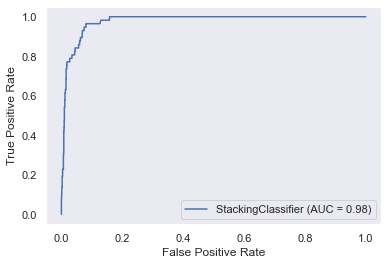

In [14]:
f_model_disp = plot_roc_curve(final_model, X_val, y_val)
plt.show()

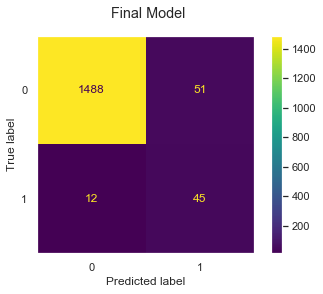

In [15]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.suptitle('Final Model')
plt.show()

# Model Validation 

In [16]:
#final_model.fit(X_train, y_train)
y_predict = final_model.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1929
           1       0.54      0.82      0.65        66

    accuracy                           0.97      1995
   macro avg       0.77      0.90      0.82      1995
weighted avg       0.98      0.97      0.97      1995



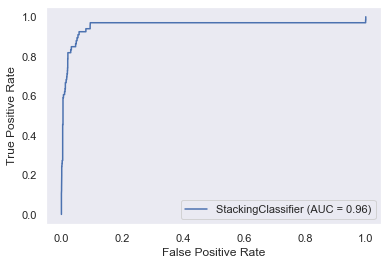

In [17]:
f_model_disp = plot_roc_curve(final_model, X_test, y_test)
plt.show()

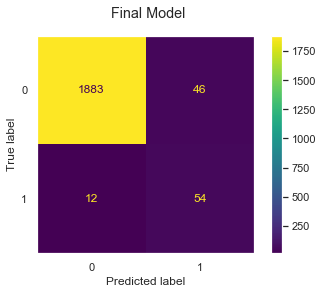

In [18]:
cm = confusion_matrix(y_test, y_predict, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.suptitle('Final Model')
plt.show()

While trying to improve recall, now 90% on macro average after improving, which is actually the positivity rate and is essential as per the business problem i.e. predicting the failure, the precision dropped. However, the model is performing extremely well on both predictions with accuracy and f1_weighted, considering the imbalance in data, of 97%. 